<a href="https://colab.research.google.com/github/Euxen/OCRwYolov8/blob/main/ANPR_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install easyocr
!pip install imutils
!pip install ultralytics==8.0.196
!pip install roboflow --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.3 MB/s eta 0:00:00


After installing our building blocks, now we can start coding out the application.

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

CV2 is our Image Reader. <br>
Matplotlib/Numpy is to help out with anything math-related and graphs. <br>
Imutils to help grab the mask/countours <br>
EasyOCR to help read from image and convert to text<br>

New Edit (Yolov8 trained model)
Here we will introduce and train a YoloV8 model with the help of a database from roboflow.

Establishing a variable to hold the root source location. Makes it reusable and easier to make dynamic pathings later on.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [13]:
!nvidia-smi

Sat Mar  9 20:45:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Installing the important dependencies to make this work.

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/201.2 GB disk)


Downloading the Number Plate database from roboflow.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets


from roboflow import Roboflow
rf = Roboflow(api_key="jADKDNfFIwo7Mpe370mV")
project = rf.workspace("roboflow-universe-projects").project("license-plate-recognition-rxg4e")
version = project.version(4)
dataset = version.download("yolov8")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-4 in yolov8:: 100%|██████████| 48488/48488 [00:10<00:00, 4731.03it/s]


Training the model with the data inside the database

In [6]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=5 imgsz=800 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 250MB/s]
New https://pypi.org/project/ultralytics/8.1.24 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/License-Plate-Recognition-4/data.yaml, epochs=20, patience=50, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_strid

After training, we need to validate that the model we trained is able to know and use what it learned.

In [7]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/License-Plate-Recognition-4/valid/labels.cache... 2046 images, 3 backgrounds, 0 corrupt: 100% 2046/2046 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 128/128 [00:40<00:00,  3.18it/s]
                   all       2046       2132      0.983      0.957      0.986      0.698
Speed: 0.7ms preprocess, 12.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


Now we look at the results.....

In [8]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		  val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		  val_batch0_pred.jpg
confusion_matrix.png				    results.png		  val_batch1_labels.jpg
events.out.tfevents.1710002367.342f0320cfe0.1367.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					    train_batch13240.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch13241.jpg  val_batch2_pred.jpg
labels.jpg					    train_batch13242.jpg  weights
P_curve.png					    train_batch1.jpg
PR_curve.png					    train_batch2.jpg


In [9]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


NameError: name 'Image' is not defined

/content


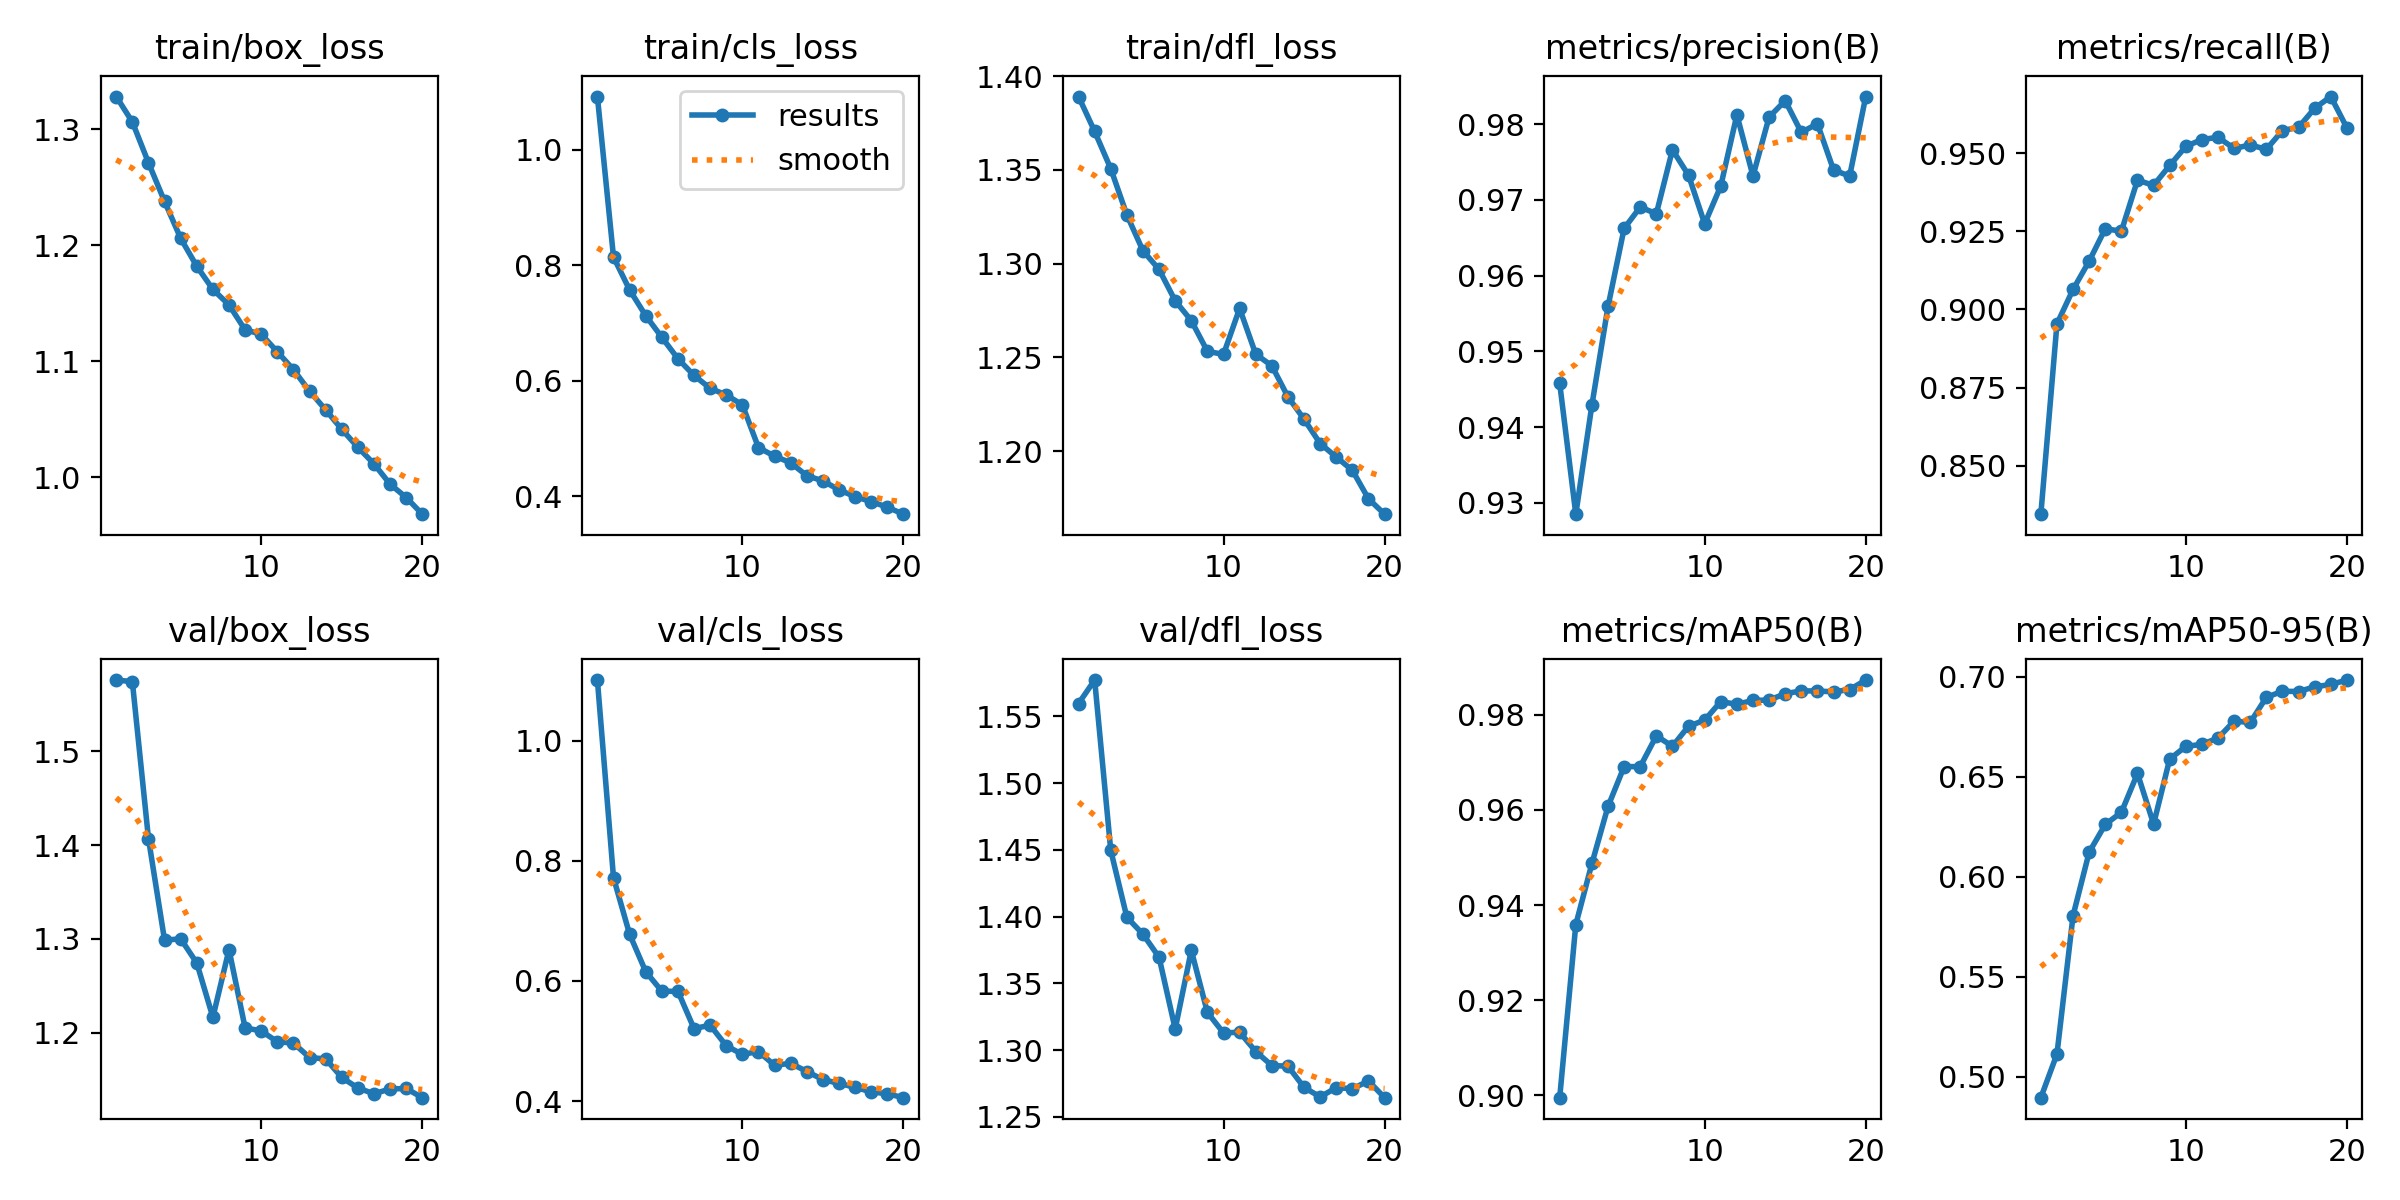

In [17]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


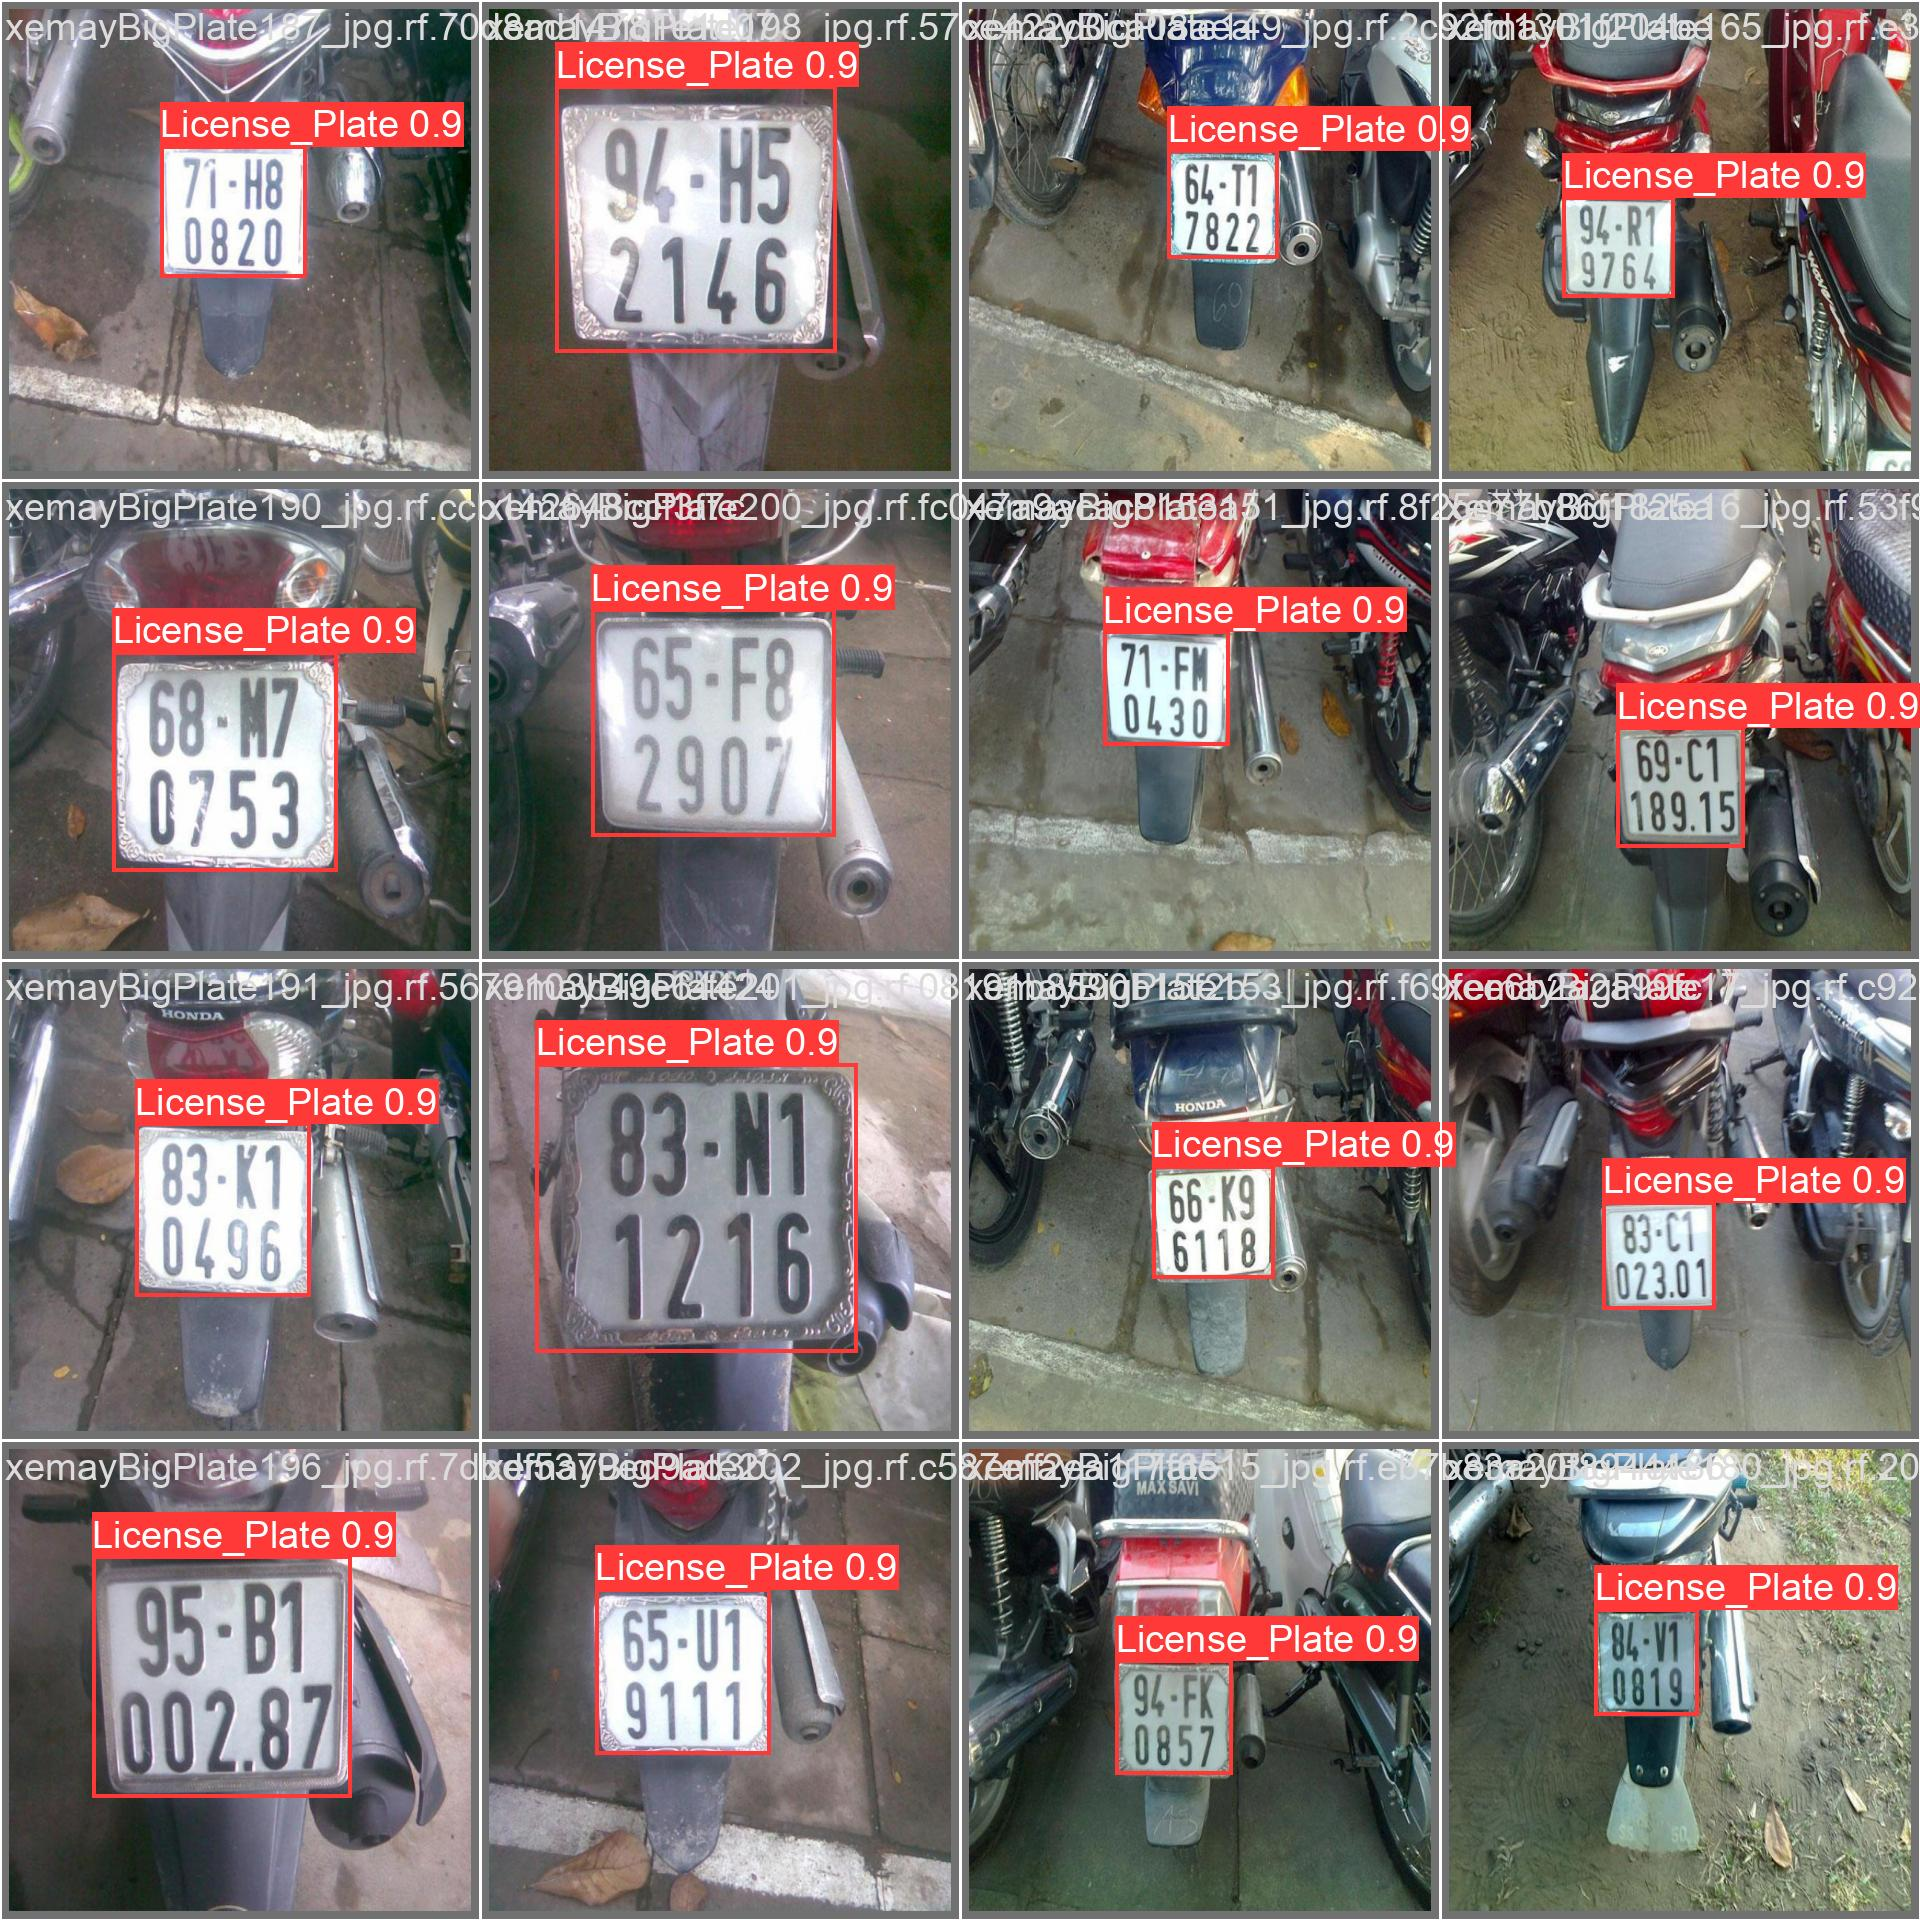

In [16]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

Now we test the results of our training and validation..

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

In [18]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict3/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

Deploy the trained weights

1. Read the Image, and then treat it the picture to be in Grayscale and Blur

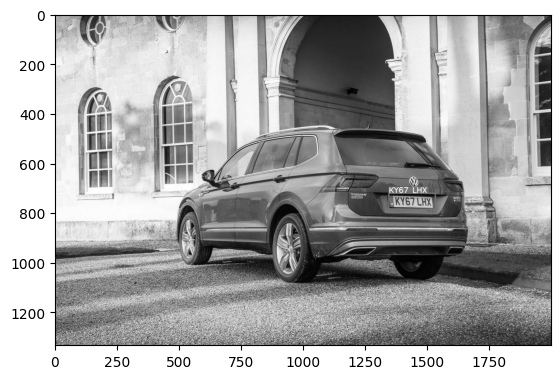

In [ ]:
img = cv2.imread('/content/VW-Tiguan-Allspace-SEL-2018-17.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

2. Apply filter and find edges for localization

In [ ]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

3. Find Contours and Apply Mask

In [ ]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [ ]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [ ]:
location

array([[[903, 333]],

       [[961, 344]],

       [[961, 459]],

       [[903, 467]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

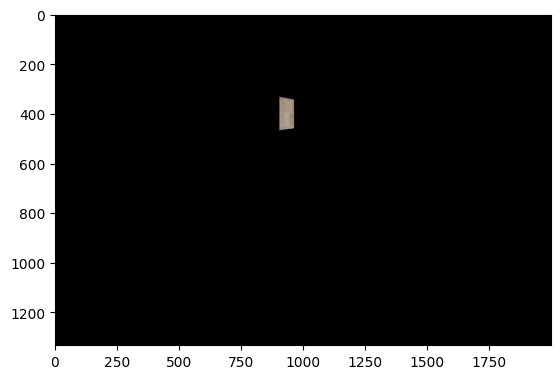

In [ ]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [ ]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

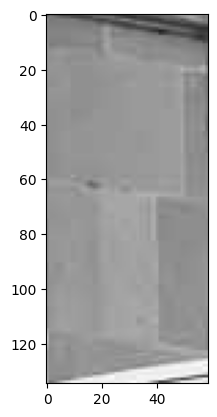

In [ ]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))


In [ ]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

[([[6, 4], [128, 4], [128, 34], [6, 34]], 'HR.26 BR.9044', 0.572802443929149)]

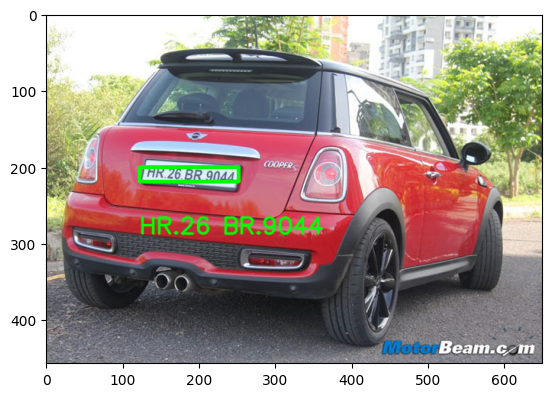

In [ ]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))